In [1]:
import numpy as np
import pandas as pd
import krippendorff
import seaborn as sns
from itertools import combinations
import matplotlib.pyplot as plt
from tqdm import tqdm

tqdm.pandas()

In [2]:
grey = (187/255, 187/255, 187/255)
darkgreen = (51/255, 117/255, 56/255)
teal = (93/255, 168/255, 153/255)
blue = (148/255, 203/255, 236/255)
yellow = (220/255, 205/255, 125/255)
red = (168/255, 96/255, 93/255)
pale_yellow = (164/255, 168/255, 93/255)


color_palette = sns.color_palette([grey, darkgreen, teal, blue, yellow, red, pale_yellow])

# Grade Analysis

In [3]:
def apply_group(id):
    if id in [1, 2, 3, 4]:
        return '1-4'
    elif id in [5, 6, 7, 8]:
        return '5-8'
    elif id in [9, 10, 11, 12]:
        return '9-12'
    elif id in [13, 14, 15, 16]:
        return '13-16'
    elif id in [17, 18, 19, 20]:
        return '17-20'
    elif id in [21, 22, 23, 24]:
        return '21-24'
    else:
        return '25-28'

In [4]:
grade_df = pd.read_csv('Menagerie/data/grades.csv', index_col=0)
grade_df = grade_df[~grade_df['grade'].isnull()]
grade_df['grade'] = pd.Categorical(grade_df['grade'],
                                         ['A++', 'A+', 'A', 'A-',
                                          'B+', 'B', 'B-',
                                          'C+', 'C', 'C-',
                                          'D+', 'D', 'D-',
                                          'F', 'NAN'])

grade_df['primary_grade'] = grade_df['grade'].apply(lambda x: x[0])
grade_df['primary_grade'] = pd.Categorical(grade_df['primary_grade'], ['A', 'B', 'C', 'D', 'F'])

grade_df['group'] = grade_df['participant_id'].apply(apply_group)
grade_df['group'] = pd.Categorical(grade_df['group'], ['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28'])


# Removed as this was accidentally duplicated
grade_df = grade_df[grade_df['assignment_number'] != 105]
grade_df

,assignment_number,comments,skill,participant_id,batch,grade,primary_grade,group
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+,B,13-16
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+,A,13-16
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-,A,13-16
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-,A,13-16
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-,A,13-16
...,...,...,...,...,...,...,...,...
15,58.0,NaN,Documentation,14,1,A++,A,13-16
16,353.0,NaN,Documentation,14,1,A++,A,13-16
17,422.0,NaN,Documentation,14,1,A++,A,13-16
18,480.0,NaN,Documentation,14,1,A++,A,13-16


# Inter-Rater Analysis

In [5]:
def calculate_all_reliability_metric(metric, grade_col='grade'):
    results_df = None
    
    for skill in ['Correctness', 'Readability', 'Code Elegance', 'Documentation']:
        for group in grade_df['group'].unique():
            try:
                metric_result = calculate_krippendorrf_alpha(skill, group, grade_col)
                
                results_df = pd.concat([results_df, pd.DataFrame({
                                        'group': group,
                                        'skill': skill,
                                        'metric_result': metric_result}, index=[0])])

                results_df['group'] = pd.Categorical(results_df['group'], ['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28'])
            except ValueError as e:
                print('Error duplicate entries check data for: ', group)
                raise e
    
    return results_df

In [6]:
def plot_heatmap(df, file_name):
    pivot_df = df.pivot(index='group', columns='skill', values='metric_result').transpose()
    g = sns.heatmap(pivot_df, annot=True, cmap=sns.color_palette("mako", as_cmap=True), square=True, vmin=-0.1, vmax=1)
    g.get_figure().savefig(f'plots/{file_name}.pdf', bbox_inches='tight')

### Krippendorrf's Alpha

In [7]:
def merge_grades(row):
    if row[row.index[0]] >= row[row.index[1]]:
        return str(row[row.index[0]]) + str(row[row.index[1]])
    else:
        return str(row[row.index[1]]) + str(row[row.index[0]])

In [8]:
# Grades are ordinal data or just stick with nominal? Are pairs of grades still ordinal?
def calculate_krippendorrf_alpha(skill, group, grade_col):
    skill_df = grade_df[grade_df['skill'] == skill][['participant_id', 'assignment_number', 'group', grade_col]].copy()
    group_df = skill_df[skill_df['group'] == group].sort_values(by='participant_id')

    group_df[grade_col] = group_df[grade_col].cat.codes
    pivot = group_df.pivot(columns='assignment_number', index='participant_id', values=grade_col)
    
    return krippendorff.alpha(pivot.to_numpy(), level_of_measurement='ordinal')

In [9]:
calculate_krippendorrf_alpha('Correctness', '13-16', 'grade')

0.20875490820626974

In [10]:
fine_alpha_df = calculate_all_reliability_metric('krippendorff', 'grade').sort_values(by='group')
fine_alpha_df

,group,skill,metric_result
0,1-4,Documentation,0.102318
0,1-4,Correctness,0.281601
0,1-4,Code Elegance,0.071930
0,1-4,Readability,0.034320
0,5-8,Documentation,-0.101600
0,5-8,Correctness,-0.069250
0,5-8,Code Elegance,0.042380
0,5-8,Readability,-0.110749
0,9-12,Readability,0.097416
0,9-12,Code Elegance,0.066531


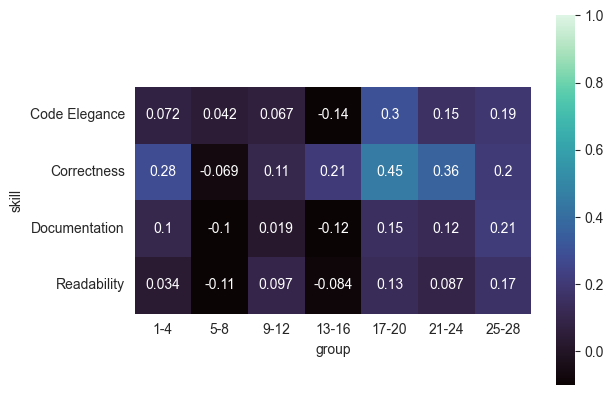

In [11]:
plot_heatmap(fine_alpha_df, 'krippendorrf_fine')

In [12]:
fine_alpha_df[['skill', 'metric_result']].groupby('skill').mean().reset_index()

,skill,metric_result
0,Code Elegance,0.098628
1,Correctness,0.220210
2,Documentation,0.054779
3,Readability,0.045598


In [13]:
fine_alpha_df[['group', 'metric_result']].groupby('group').mean().reset_index()

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_91964/1232685465.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fine_alpha_df[['group', 'metric_result']].groupby('group').mean().reset_index()


,group,metric_result
0,1-4,0.122543
1,5-8,-0.059805
2,9-12,0.072266
3,13-16,-0.032394
4,17-20,0.257109
5,21-24,0.181666
6,25-28,0.192243


## Distance between grades

In [14]:
def get_grade(df, grade_col, group, skill, assignment_number, participant_id):
    grade = df[(df['group'] == group) &
                         (df['skill'] == skill) &
                         (df['assignment_number'] == assignment_number) &
                         (df['participant_id'] == participant_id)][grade_col]

    if grade.empty:
        return None
    return grade

In [15]:
def generate_grade_pairs(df, grade_col, group, skill, assignment_number):
    group_bounds = group.split('-')
    pairs = combinations(range(int(group_bounds[0]), int(group_bounds[1]) + 1), r=2)
    
    grade_pairs_df = None
    
    
    for idx, pair in enumerate(pairs):
        grade_1 = get_grade(df, grade_col, group, skill, assignment_number, pair[0])
        grade_2 = get_grade(df, grade_col, group, skill,assignment_number, pair[1])
    
        if grade_pairs_df is None:
            grade_pairs_df = pd.DataFrame({'group': group,
                                              'skill': skill,
                                              'assignment_number': assignment_number,
                                              'participant_id_1': pair[0],
                                              'participant_id_2': pair[1],
                                              'grade_1': grade_1,
                                              'grade_2': grade_2
                                              }, index=[idx])
        else:
            grade_pairs_df = pd.concat([
                grade_pairs_df,
                pd.DataFrame({'group': group, 'assignment_number': assignment_number, 'skill': skill,
                              'participant_id_1': pair[0],
                              'participant_id_2': pair[1],
                              'grade_1': grade_1,
                              'grade_2': grade_2
                              }, index=[idx])]
            )


    grade_pairs_df['group'] = pd.Categorical(grade_pairs_df['group'], ['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28'])
    return grade_pairs_df
        

In [16]:
def get_distance_df(df, grade_col):
    dist_df = None
    
    for group in tqdm(df['group'].unique()):
        for skill in df['skill'].unique():
            for n in df[(df['group'] == group) &
                               (df['skill'] == skill)]['assignment_number'].unique():
                if  dist_df is None:
                    dist_df = generate_grade_pairs(df, grade_col, group, skill, n)
                else:
                    dist_df = pd.concat([dist_df, generate_grade_pairs(df, grade_col, group, skill, n)])
    
    dist_df = dist_df.dropna()
    dist_df['grade_1_code'] = dist_df['grade_1'].cat.codes
    dist_df['grade_2_code'] = dist_df['grade_2'].cat.codes
    dist_df['distance'] = abs(dist_df['grade_1_code'] - dist_df['grade_2_code'])
    
    return dist_df
            

#### Boxplot

##### Fine

  0%|          | 0/7 [00:00<?, ?it/s]/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_91964/3626878353.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dist_df = pd.concat([dist_df, generate_grade_pairs(df, grade_col, group, skill, n)])
 14%|█▍        | 1/7 [00:01<00:07,  1.30s/it]/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_91964/195055873.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  grade_pairs_df = pd.concat([
/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/

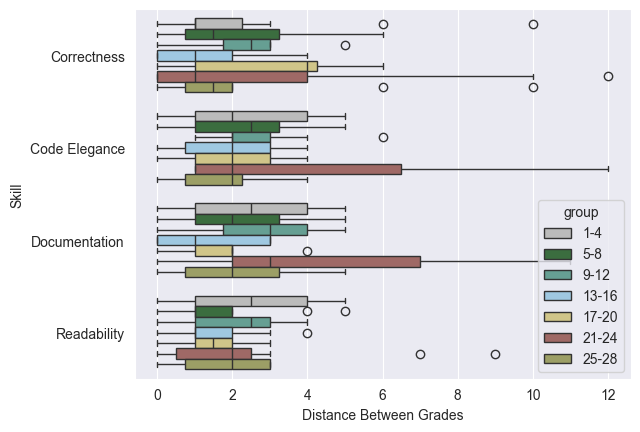

In [17]:
fine_dist_df = get_distance_df(grade_df, 'grade').sort_values(by='group')
g = sns.boxplot(fine_dist_df, y='skill', x='distance', hue='group', palette=color_palette)
g.set(xlabel='Distance Between Grades', ylabel='Skill')
g.get_figure().savefig('plots/fine_grade_distance.pdf', bbox_inches='tight')

In [18]:
fine_dist_df.groupby('skill')['distance'].mean()

skill
Code Elegance    2.385542
Correctness      2.313253
Documentation    2.433735
Readability      1.927711
Name: distance, dtype: float64

# Intra-Rater Relability

In [19]:
DUPLICATE_MAP = {
    680: 144,
    681: 559,
    682: 97,
    683: 358,
    684: 389,
    685: 160,
    686: 176
}

In [20]:
intra_rater_df = grade_df[grade_df['assignment_number'].isin(list(DUPLICATE_MAP.keys())+list(DUPLICATE_MAP.values()))][['assignment_number', 'skill', 'participant_id', 'batch', 'grade']]
intra_rater_df = intra_rater_df.sort_values('grade')
intra_rater_df

,assignment_number,skill,participant_id,batch,grade
7,680.0,Correctness,3,2,A++
13,685.0,Readability,22,2,A++
9,686.0,Code Elegance,25,2,A++
7,680.0,Readability,3,2,A++
16,684.0,Code Elegance,18,2,A++
...,...,...,...,...,...
14,682.0,Documentation,10,2,F
7,97.0,Code Elegance,10,1,F
7,97.0,Correctness,10,1,F
7,97.0,Readability,10,1,F


### Map replacement IDs to original IDs

In [21]:
intra_rater_df['assignment_number'] = intra_rater_df['assignment_number'].apply(lambda x: x if x not in DUPLICATE_MAP.keys() else DUPLICATE_MAP[x])
intra_rater_df['grade_code'] = intra_rater_df['grade'].cat.codes
intra_rater_df

,assignment_number,skill,participant_id,batch,grade,grade_code
7,144.0,Correctness,3,2,A++,0
13,160.0,Readability,22,2,A++,0
9,176.0,Code Elegance,25,2,A++,0
7,144.0,Readability,3,2,A++,0
16,389.0,Code Elegance,18,2,A++,0
...,...,...,...,...,...,...
14,97.0,Documentation,10,2,F,13
7,97.0,Code Elegance,10,1,F,13
7,97.0,Correctness,10,1,F,13
7,97.0,Readability,10,1,F,13


In [22]:
pivot = intra_rater_df.pivot(index=['assignment_number', 'skill', 'participant_id'], columns='batch', values='grade').reset_index()
pivot.columns = ['assignment_number', 'skill', 'participant_id', 'grade_1', 'grade_2']
pivot

,assignment_number,skill,participant_id,grade_1,grade_2
0,97.0,Code Elegance,9,A-,B+
1,97.0,Code Elegance,10,F,F
2,97.0,Code Elegance,11,A-,A+
3,97.0,Code Elegance,12,A-,B
4,97.0,Correctness,9,B+,A
...,...,...,...,...,...
107,559.0,Documentation,8,A,A
108,559.0,Readability,5,A-,B+
109,559.0,Readability,6,A-,A++
110,559.0,Readability,7,A+,A+


## Distance between grade notches

In [23]:
pivot['grade_1_code'] = pivot['grade_1'].cat.codes
pivot['grade_2_code'] = pivot['grade_2'].cat.codes
pivot['distance'] = pivot['grade_1_code'] - pivot['grade_2_code']
pivot

,assignment_number,skill,participant_id,grade_1,grade_2,grade_1_code,grade_2_code,distance
0,97.0,Code Elegance,9,A-,B+,3,4,-1
1,97.0,Code Elegance,10,F,F,13,13,0
2,97.0,Code Elegance,11,A-,A+,3,1,2
3,97.0,Code Elegance,12,A-,B,3,5,-2
4,97.0,Correctness,9,B+,A,4,2,2
...,...,...,...,...,...,...,...,...
107,559.0,Documentation,8,A,A,2,2,0
108,559.0,Readability,5,A-,B+,3,4,-1
109,559.0,Readability,6,A-,A++,3,0,3
110,559.0,Readability,7,A+,A+,1,1,0


/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_91964/181745326.py:1: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  dist_plt = sns.scatterplot(intra_rater_df[intra_rater_df['skill'] == 'Correctness'], x='participant_id', y='grade', style='batch', hue='batch', palette=color_palette, markers=['s', 'd'], zorder=5)


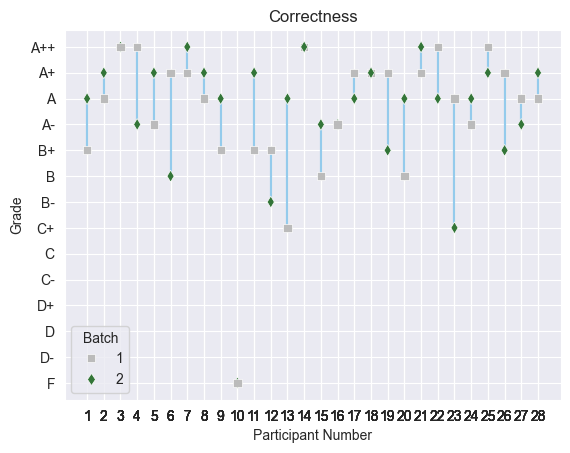

In [24]:
dist_plt = sns.scatterplot(intra_rater_df[intra_rater_df['skill'] == 'Correctness'], x='participant_id', y='grade', style='batch', hue='batch', palette=color_palette, markers=['s', 'd'], zorder=5)

for index, row in intra_rater_df[intra_rater_df['skill'] == 'Correctness'].iterrows():
    participant_id = row['participant_id']
    grade_1_code = intra_rater_df[(intra_rater_df['skill'] == 'Correctness') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 1)]['grade_code']

    grade_2_code = intra_rater_df[(intra_rater_df['skill'] == 'Correctness') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 2)]['grade_code']

    line = dist_plt.plot([participant_id, participant_id], [grade_1_code, grade_2_code])
    plt.setp(line, color=blue)
    
dist_plt.set(ylabel='Grade', xlabel='Participant Number', title='Correctness', xticks=intra_rater_df['participant_id'])
dist_plt.legend(title='Batch')
dist_plt.get_figure().savefig('plots/correctness_distance.pdf', bbox_inches='tight')

In [25]:
pivot[pivot['skill'] == 'Correctness']['distance'].abs().mean()

1.7857142857142858

In [26]:
pivot[(pivot['skill'] == 'Correctness') & (pivot['distance'] == 0)]['participant_id']

5     10
22     3
69    14
71    16
85    18
Name: participant_id, dtype: int64

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_91964/2282567131.py:1: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  dist_plt = sns.scatterplot(intra_rater_df[intra_rater_df['skill'] == 'Code Elegance'], x='participant_id', y='grade', style='batch', hue='batch', palette=color_palette, markers=['s', 'd'], zorder=5)


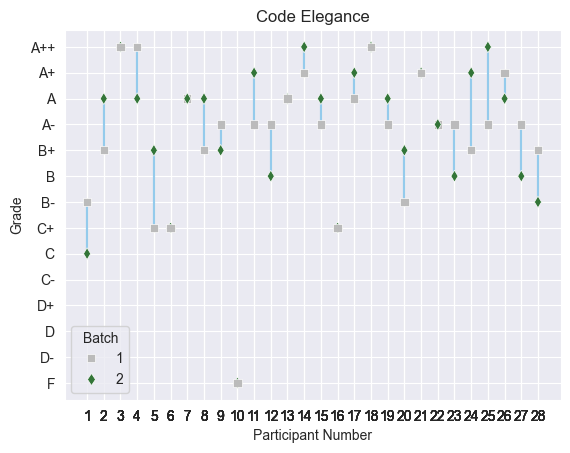

In [27]:
dist_plt = sns.scatterplot(intra_rater_df[intra_rater_df['skill'] == 'Code Elegance'], x='participant_id', y='grade', style='batch', hue='batch', palette=color_palette, markers=['s', 'd'], zorder=5)

for index, row in intra_rater_df[intra_rater_df['skill'] == 'Code Elegance'].iterrows():
    participant_id = row['participant_id']
    grade_1_code = intra_rater_df[(intra_rater_df['skill'] == 'Code Elegance') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 1)]['grade_code']

    grade_2_code = intra_rater_df[(intra_rater_df['skill'] == 'Code Elegance') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 2)]['grade_code']

    line = dist_plt.plot([participant_id, participant_id], [grade_1_code, grade_2_code])
    plt.setp(line, color=blue)

dist_plt.set(ylabel='Grade', xlabel='Participant Number', title='Code Elegance', xticks=intra_rater_df['participant_id'])
dist_plt.legend(title='Batch')
dist_plt.get_figure().savefig('plots/code_elegance_distance.pdf', bbox_inches='tight')

In [28]:
pivot[pivot['skill'] == 'Code Elegance']['distance'].abs().mean()

1.25

In [29]:
pivot[(pivot['skill'] == 'Code Elegance') & (pivot['distance'] == 0)]['participant_id']

1     10
18     3
32    21
33    22
64    13
67    16
81    18
97     6
98     7
Name: participant_id, dtype: int64

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_91964/3387906373.py:1: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  dist_plt = sns.scatterplot(intra_rater_df[intra_rater_df['skill'] == 'Readability'], x='participant_id', y='grade', style='batch', hue='batch', palette=color_palette, markers=['s', 'd'], zorder=5)


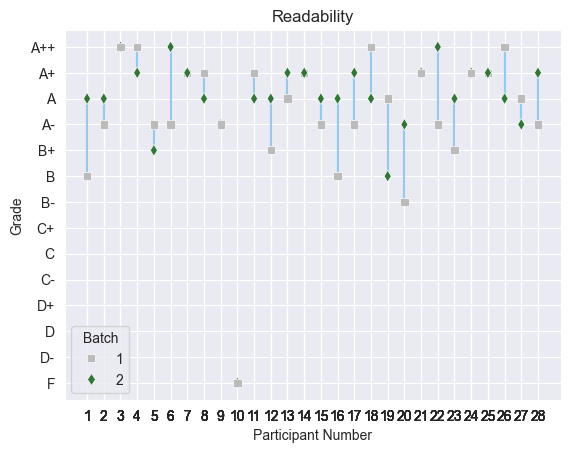

In [30]:
dist_plt = sns.scatterplot(intra_rater_df[intra_rater_df['skill'] == 'Readability'], x='participant_id', y='grade', style='batch', hue='batch', palette=color_palette, markers=['s', 'd'], zorder=5)

for index, row in intra_rater_df[intra_rater_df['skill'] == 'Readability'].iterrows():
    participant_id = row['participant_id']
    grade_1_code = intra_rater_df[(intra_rater_df['skill'] == 'Readability') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 1)]['grade_code']

    grade_2_code = intra_rater_df[(intra_rater_df['skill'] == 'Readability') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 2)]['grade_code']

    line = dist_plt.plot([participant_id, participant_id], [grade_1_code, grade_2_code])
    plt.setp(line, color=blue)

dist_plt.set(ylabel='Grade', xlabel='Participant Number', title='Readability', xticks=intra_rater_df['participant_id'])
dist_plt.legend(title='Batch')
dist_plt.get_figure().savefig('plots/readability_distance.pdf', bbox_inches='tight')

In [31]:
pivot[pivot['skill'] == 'Readability']['distance'].abs().mean()

1.3571428571428572

In [32]:
pivot[(pivot['skill'] == 'Readability') & (pivot['distance'] == 0)]['participant_id']

12      9
13     10
30      3
44     21
47     24
60     25
77     14
110     7
Name: participant_id, dtype: int64

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_91964/2119967665.py:1: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  dist_plt = sns.scatterplot(intra_rater_df[intra_rater_df['skill'] == 'Documentation'], x='participant_id', y='grade', style='batch', hue='batch', palette=color_palette, markers=['s', 'd'], zorder=5)


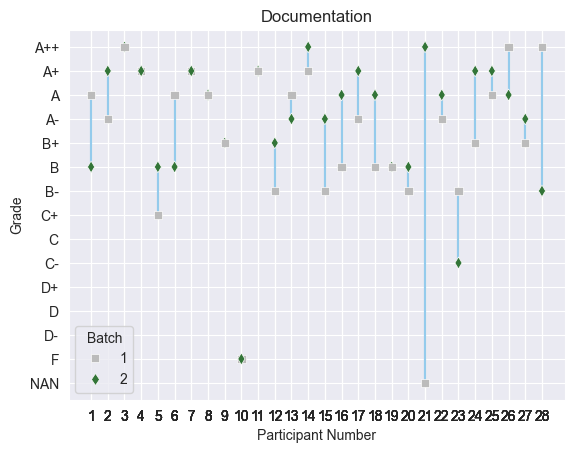

In [33]:
dist_plt = sns.scatterplot(intra_rater_df[intra_rater_df['skill'] == 'Documentation'], x='participant_id', y='grade', style='batch', hue='batch', palette=color_palette, markers=['s', 'd'], zorder=5)

for index, row in intra_rater_df[intra_rater_df['skill'] == 'Documentation'].iterrows():
    participant_id = row['participant_id']
    grade_1_code = intra_rater_df[(intra_rater_df['skill'] == 'Documentation') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 1)]['grade_code']

    grade_2_code = intra_rater_df[(intra_rater_df['skill'] == 'Documentation') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 2)]['grade_code']

    line = dist_plt.plot([participant_id, participant_id], [grade_1_code, grade_2_code])
    plt.setp(line, color=blue, zorder=1)

dist_plt.set(ylabel='Grade', xlabel='Participant Number', title='Documentation', xticks=intra_rater_df['participant_id'])
dist_plt.legend(title='Batch')
dist_plt.get_figure().savefig('plots/documentation_distance.pdf', bbox_inches='tight')

In [34]:
pivot[pivot['skill'] == 'Documentation']['distance'].abs().mean()

2.0357142857142856

In [35]:
pivot[(pivot['skill'] == 'Documentation') & (pivot['distance'] == 0)]['participant_id']

8       9
9      10
10     11
26      3
27      4
90     19
106     7
107     8
Name: participant_id, dtype: int64

# Summary of Grades per skill

In [36]:
grade_count_df = grade_df[['skill', 'grade', 'assignment_number']].groupby(['skill', 'grade']).count().reset_index().rename(columns={'assignment_number': 'count'})
grade_count_df

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_91964/1988006025.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grade_count_df = grade_df[['skill', 'grade', 'assignment_number']].groupby(['skill', 'grade']).count().reset_index().rename(columns={'assignment_number': 'count'})


,skill,grade,count
0,Code Elegance,A++,148
1,Code Elegance,A+,197
2,Code Elegance,A,189
3,Code Elegance,A-,132
4,Code Elegance,B+,116
5,Code Elegance,B,127
6,Code Elegance,B-,73
7,Code Elegance,C+,53
8,Code Elegance,C,21
9,Code Elegance,C-,13


Rectangle(xy=(0, 0), width=0, height=0, angle=0)


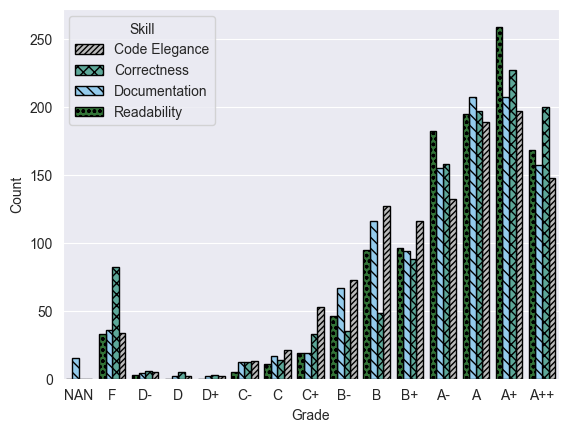

In [66]:
grade_plt = sns.barplot(x='grade', y='count', data=grade_count_df, hue='skill')

hatches = ['//', 'x', '\\', 'o']
colors = [grey, teal, blue, darkgreen]
styles = zip(hatches, colors)


for style, these_bars in zip(styles, grade_plt.containers):
    for this_bar in these_bars:
        this_bar.set_hatch(3 * style[0])
        this_bar.set_facecolor(style[1])
        this_bar.set_edgecolor('black')

grade_plt.set(xlabel='Grade', ylabel='Count')
handles = grade_plt.get_legend_handles_labels()[0]
print(handles[0])

for i in range(len(handles)):
    handles[i].set_facecolor(colors[i])
    handles[i].set_hatch(3 * hatches[i])
    handles[i].set_edgecolor('black')


grade_plt.legend(title='Skill')
grade_plt.invert_xaxis()
grade_plt.get_figure().savefig('plots/grade_count.pdf', bbox_inches='tight')

In [38]:
lower_b = grade_count_df[~grade_count_df['grade'].isin(['A++', 'A+', 'A', 'A-', 'B+', 'B', 'B-'])]['count'].sum()

(lower_b / grade_count_df['count'].sum()) * 100

10.423232778027916

## Grades per assignment

In [39]:
per_assignment_df = grade_df[['assignment_number', 'participant_id', 'skill', 'grade', 'group']].copy()
per_assignment_df['grade_code'] = per_assignment_df['grade'].cat.codes
per_assignment_df['assignment_number'] = pd.Categorical(per_assignment_df['assignment_number'])

per_assignment_df

,assignment_number,participant_id,skill,grade,group,grade_code
0,18.0,15,Readability,B+,13-16,4
1,620.0,15,Readability,A+,13-16,1
2,466.0,15,Readability,A-,13-16,3
3,591.0,15,Readability,A-,13-16,3
4,587.0,15,Readability,A-,13-16,3
...,...,...,...,...,...,...
15,58.0,14,Documentation,A++,13-16,0
16,353.0,14,Documentation,A++,13-16,0
17,422.0,14,Documentation,A++,13-16,0
18,480.0,14,Documentation,A++,13-16,0


In [40]:
grade_code_dict = {str(k):v for k, v in dict(enumerate(per_assignment_df['grade'].cat.categories)).items()}
grade_code_dict

{'0': 'A++',
 '1': 'A+',
 '2': 'A',
 '3': 'A-',
 '4': 'B+',
 '5': 'B',
 '6': 'B-',
 '7': 'C+',
 '8': 'C',
 '9': 'C-',
 '10': 'D+',
 '11': 'D',
 '12': 'D-',
 '13': 'F',
 '14': 'NAN'}

In [41]:
def plot_grade_per_assignment(skill, group):
    a4_dims = (8.4, 10.7)
    fig, ax = plt.subplots(figsize=a4_dims)

    data = per_assignment_df[(per_assignment_df['skill'] == skill) & (per_assignment_df['group'] == group)]
    range_df = abs(data[['assignment_number', 'grade_code']].groupby(['assignment_number']).min().dropna() - data[['assignment_number', 'grade_code']].groupby(['assignment_number']).max().dropna())
    range_df.columns = ['range']

    data = data.merge(range_df, on='assignment_number', how='left')
    plot_order = data.sort_values(by='range', ascending=False)['assignment_number'].values
    
    ax = sns.pointplot(data, x='grade_code', y='assignment_number',
                       markers='d', markersize=4, linestyle='None', order=plot_order,
                       errorbar=lambda x: (x.min(), x.max()), err_kws=({'alpha': 0.5}), capsize=.5
                       )
    ax.set_xticks(range(len(grade_code_dict)))
    
    labels = [grade_code_dict[item.get_text()] for item in ax.get_xticklabels() if item.get_text() in (grade_code_dict.keys())]
    ax.set_xticklabels(labels)
    ax.set_xlabel('Grade')
    ax.set_ylabel('Assignment Number')
    ax.set_title(f'Skill = {skill} - Group = {group}')
    ax.invert_xaxis()
    
    ax.get_figure().savefig(f'plots/grade_per_assignment/grade_per_assignment_{skill}_{group}.pdf', bbox_inches='tight')
    plt.close(ax.get_figure())

plot_grade_per_assignment('Correctness', '1-4')

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_91964/2363378021.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  range_df = abs(data[['assignment_number', 'grade_code']].groupby(['assignment_number']).min().dropna() - data[['assignment_number', 'grade_code']].groupby(['assignment_number']).max().dropna())
/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_91964/2363378021.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  range_df = abs(data[['assignment_number', 'grade_code']].groupby(['assignment_number']).min().dropna() - data[['assignment_number', 'grade_code']].groupby(['assignmen

In [42]:
for skill in per_assignment_df['skill'].unique():
    for group in per_assignment_df['group'].unique():
        plot_grade_per_assignment(skill, group)

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_91964/2363378021.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  range_df = abs(data[['assignment_number', 'grade_code']].groupby(['assignment_number']).min().dropna() - data[['assignment_number', 'grade_code']].groupby(['assignment_number']).max().dropna())
/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_91964/2363378021.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  range_df = abs(data[['assignment_number', 'grade_code']].groupby(['assignment_number']).min().dropna() - data[['assignment_number', 'grade_code']].groupby(['assignmen

## Good, medium and bad grading

In [43]:
range_df = abs(per_assignment_df[['skill', 'assignment_number', 'grade_code']].groupby(['skill', 'assignment_number']).min().dropna() - per_assignment_df[['assignment_number', 'grade_code']].groupby(['assignment_number']).max().dropna())
range_df.columns = ['range']
range_df

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_91964/2445823822.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  range_df = abs(per_assignment_df[['skill', 'assignment_number', 'grade_code']].groupby(['skill', 'assignment_number']).min().dropna() - per_assignment_df[['assignment_number', 'grade_code']].groupby(['assignment_number']).max().dropna())
/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_91964/2445823822.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  range_df = abs(per_assignment_df[['skill', 'assignment_number', 'grade_code']].groupby(['skill', 'assignment_number']).min

range
skill         assignment_number       
Code Elegance 2.0                    8
              6.0                    2
              8.0                    5
              9.0                    4
              10.0                  13
...                                ...
Readability   682.0                 11
              683.0                  6
              684.0                  4
              685.0                  9
              686.0                  5

[1112 rows x 1 columns]

In [44]:
def grade_bucket(grade_dist):
    if grade_dist <= 2:
        return 'Good \n (Grade Range <= 2)'
    elif grade_dist == 3:
        return 'Mediocre \n (Grade Range = 3)'
    else:
        return 'Poor \n (Grade Range > 3)'

range_df['Grading Reliability'] = range_df['range'].map(grade_bucket)
range_df

range         Grading Reliability
skill         assignment_number                                   
Code Elegance 2.0                    8   Poor \n (Grade Range > 3)
              6.0                    2  Good \n (Grade Range <= 2)
              8.0                    5   Poor \n (Grade Range > 3)
              9.0                    4   Poor \n (Grade Range > 3)
              10.0                  13   Poor \n (Grade Range > 3)
...                                ...                         ...
Readability   682.0                 11   Poor \n (Grade Range > 3)
              683.0                  6   Poor \n (Grade Range > 3)
              684.0                  4   Poor \n (Grade Range > 3)
              685.0                  9   Poor \n (Grade Range > 3)
              686.0                  5   Poor \n (Grade Range > 3)

[1112 rows x 2 columns]

In [45]:
grade_quality_df = pd.merge(range_df, per_assignment_df, how='outer', on=['assignment_number', 'skill'])[['skill', 'grade', 'Grading Reliability']]

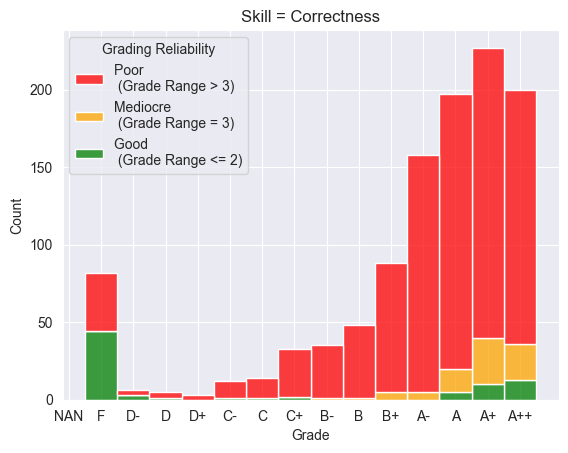

In [46]:
g = sns.histplot(grade_quality_df[grade_quality_df['skill'] == 'Correctness'], x='grade', hue='Grading Reliability', multiple='stack', palette=sns.color_palette(['red', 'orange', 'green']))
g.set(title='Skill = Correctness', xlabel='Grade', ylabel='Count')
g.invert_xaxis()
# plt.legend(title='Grading Reliability')

In [74]:
# Modified from: https://stackoverflow.com/questions/69846902/how-to-plot-stacked-100-bar-plot-with-seaborn-for-categorical-data
def plot_grade_relability(skill):
    distribution = pd.crosstab(grade_quality_df[grade_quality_df['skill'] == skill]['grade'], grade_quality_df[grade_quality_df['skill'] == skill]['Grading Reliability'], normalize='index')
    
    rel_plot = sns.barplot(data=distribution.cumsum(axis=1).stack().reset_index(name='Proportion'),
                    x='grade', y='Proportion', hue='Grading Reliability',
                    hue_order = distribution.columns[::-1],   # reverse hue order so that the taller bars got plotted first
                    dodge=False
                )
    rel_plot.set(xlabel='Grade')
    
    hatches = ['//', 'x', '\\']
    colors = ['red', 'orange', 'green']
    styles = zip(hatches, colors)
    
    
    for style, these_bars in zip(styles, rel_plot.containers):
        for this_bar in these_bars:
            this_bar.set_hatch(3 * style[0])
            this_bar.set_facecolor(style[1])
            this_bar.set_edgecolor('black')
    
    handles = rel_plot.get_legend_handles_labels()[0]
    
    for i in range(len(handles)):
        handles[i].set_facecolor(colors[i])
        handles[i].set_hatch(3 * hatches[i])
        handles[i].set_edgecolor('black')

    rel_plot.legend(title='Grading Reliability')
    rel_plot.invert_xaxis()
    sns.move_legend(rel_plot, 'upper left', bbox_to_anchor=(1, 1))

    rel_plot.get_figure().savefig(f'plots/grade_reliability_{skill}.pdf', bbox_inches='tight')
    plt.close(rel_plot.get_figure())
    
for skill in grade_quality_df['skill'].unique():
    plot_grade_relability(skill)

Code Elegance
Correctness
Documentation
Readability
